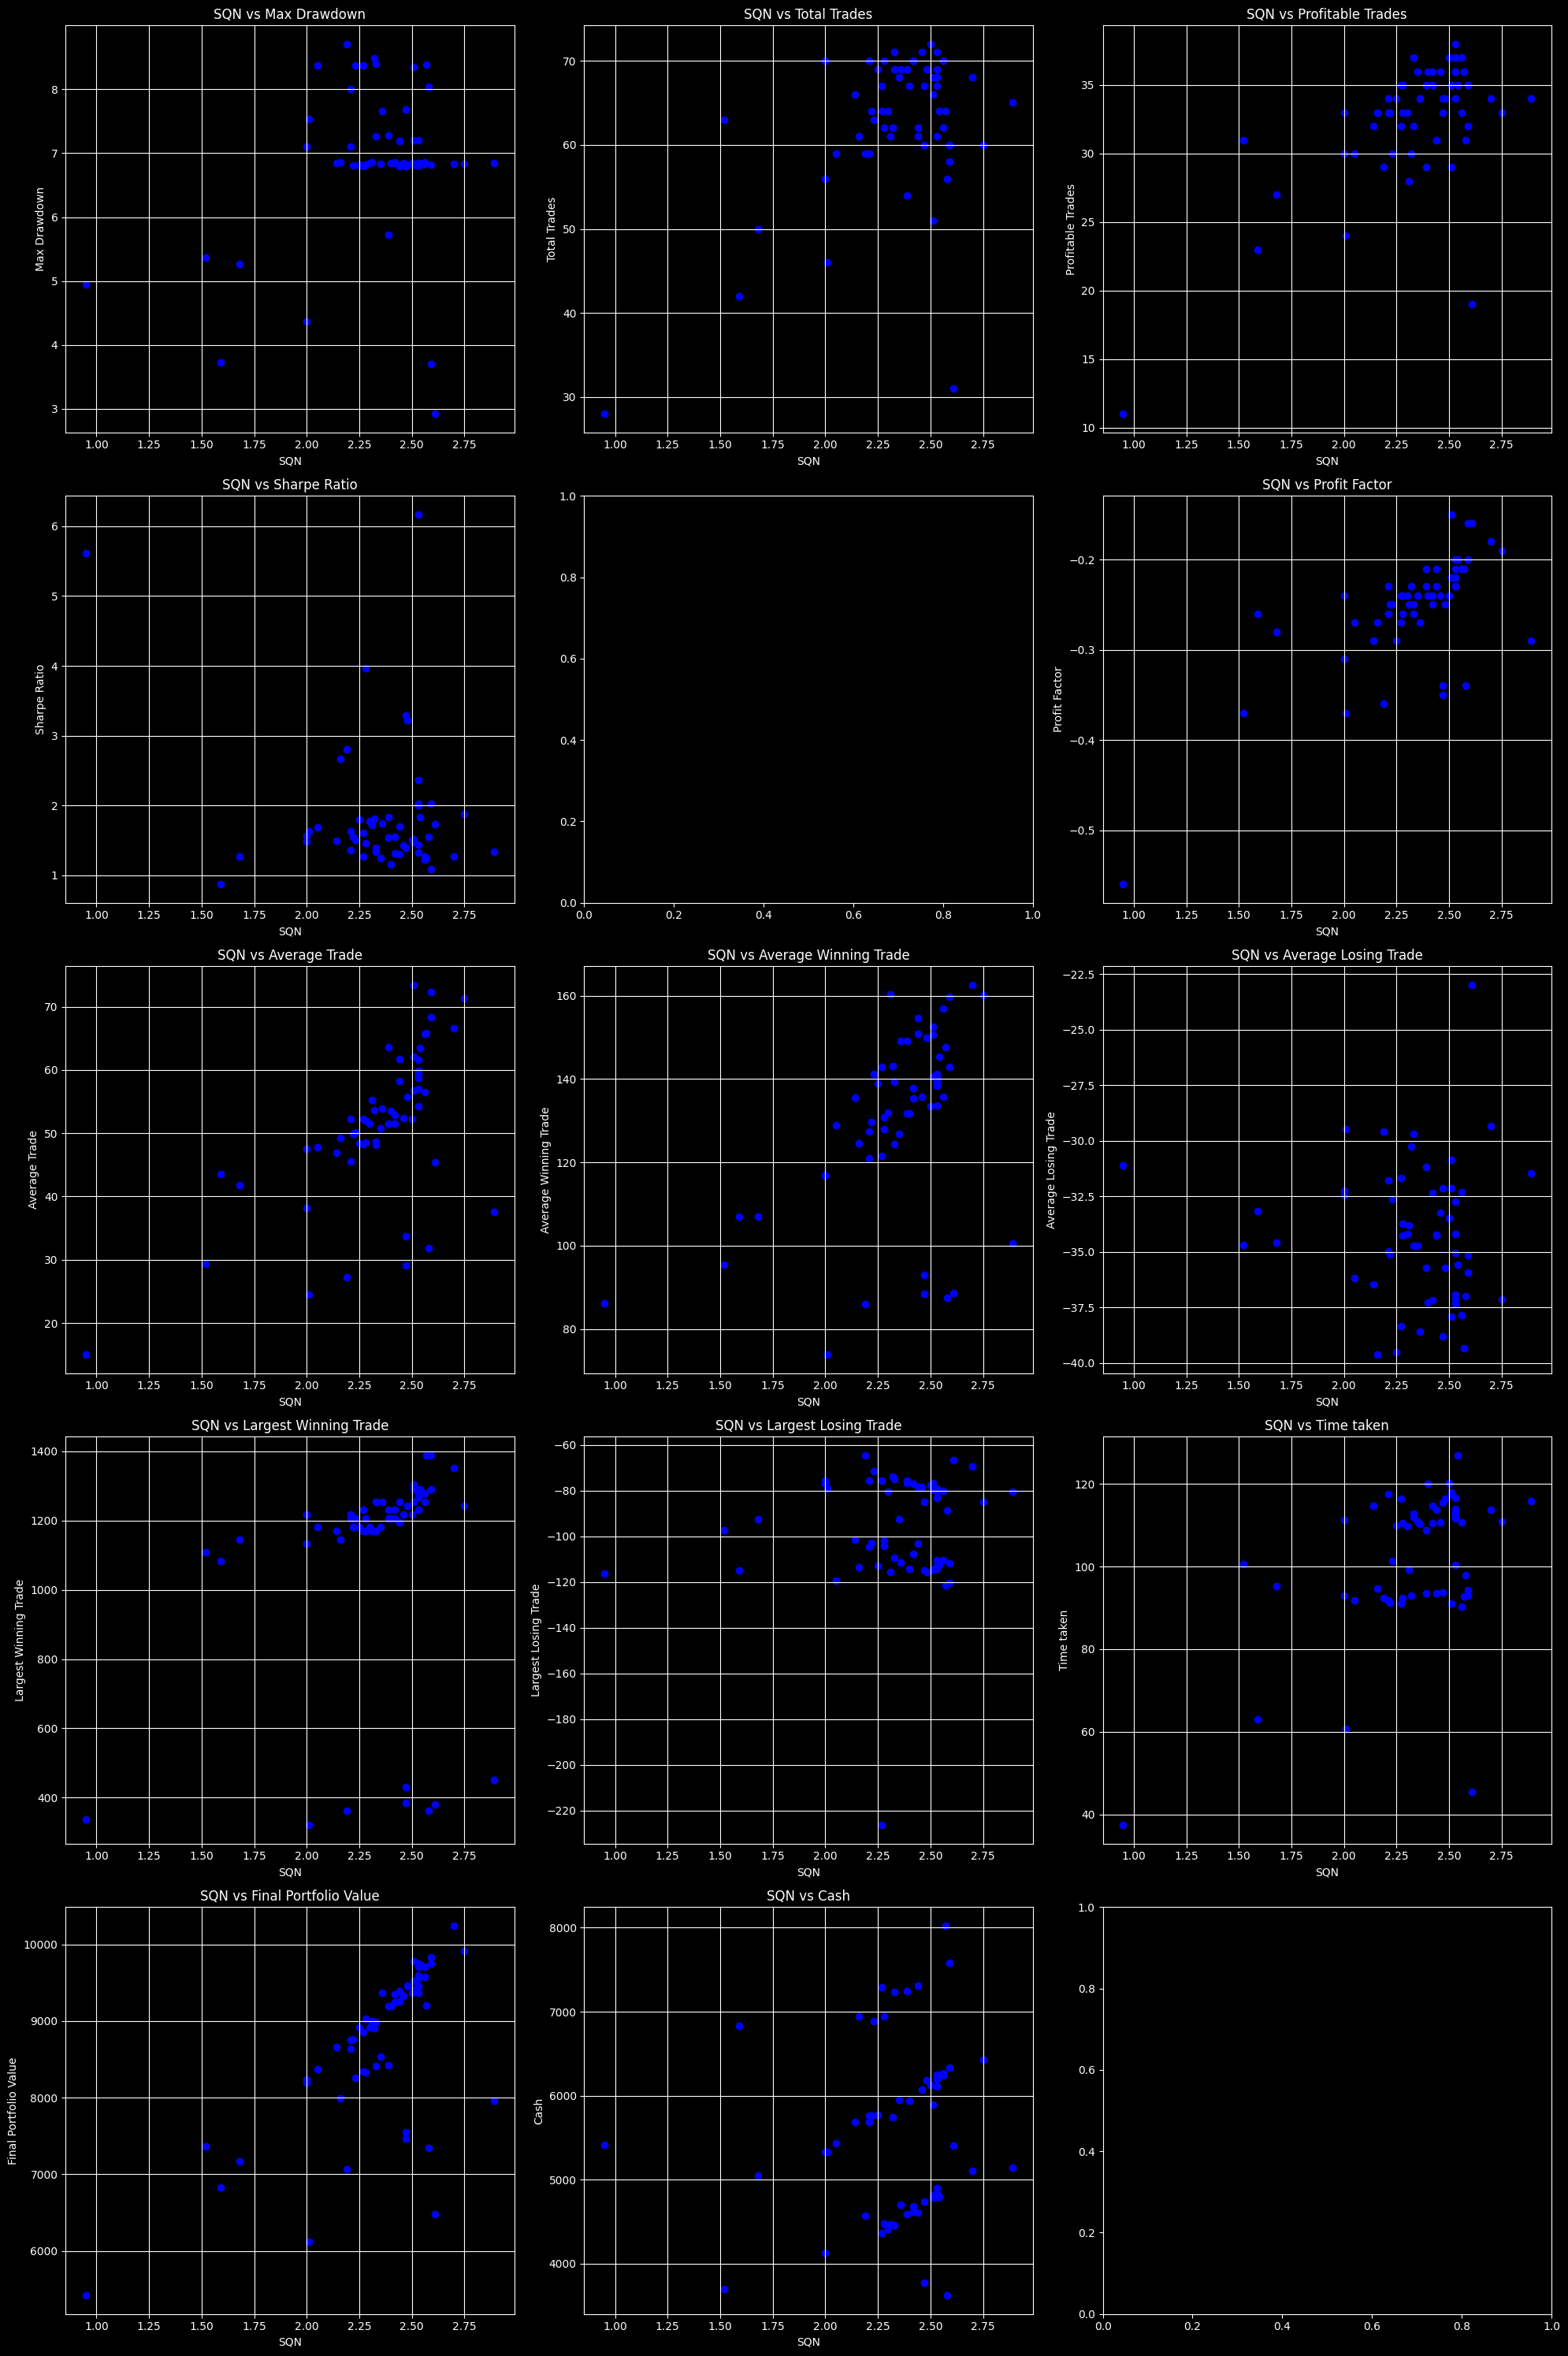

In [2]:
import matplotlib.pyplot as plt
import re
import time
# Path to the log file
log_file_path = "__BrokerLog.log"

# Dictionary to store the data
data = {
    "Max Drawdown": [],
    "Total Trades": [],
    "Profitable Trades": [],
    "Sharpe Ratio": [],
    "SQN": [],
    "Profit Factor": [],
    "Average Trade": [],
    "Average Winning Trade": [],
    "Average Losing Trade": [],
    "Largest Winning Trade": [],
    "Largest Losing Trade": [],
    "Time taken": [],
    "Final Portfolio Value": [],
    "Cash": []
}

# Define regex patterns for each attribute
attribute_patterns = {
    "Max Drawdown": r"Max Drawdown: ([0-9.]+)%",
    "Total Trades": r"Total Trades: ([0-9]+)",
    "Profitable Trades": r"Profitable Trades: ([0-9]+)",
    "Sharpe Ratio": r"Sharpe Ratio: ([0-9.]+)",
    "SQN": r"SQN: ([0-9.]+)",
    "Profit Factor": r"Profit Factor: ([-0-9.]+)",
    "Average Trade": r"Average Trade: ([0-9.]+)",
    "Average Winning Trade": r"Average Winning Trade: ([0-9.]+)",
    "Average Losing Trade": r"Average Losing Trade: ([-0-9.]+)",
    "Largest Winning Trade": r"Largest Winning Trade: ([0-9.]+)",
    "Largest Losing Trade": r"Largest Losing Trade: ([-0-9.]+)",
    "Time taken": r"Time taken: ([0-9.]+) seconds",
    "Final Portfolio Value": r"Final Portfolio Value: \$([0-9,.]+)",
    "Cash": r"Cash: \$([0-9,.]+)"
}

# Read the log file and process each line
with open(log_file_path, 'r') as file:
    for line in file:
        # Check for each attribute and append to the corresponding list
        for attribute, pattern in attribute_patterns.items():
            match = re.search(pattern, line)
            if match:
                value = float(match.group(1).replace(',', '')) if attribute in ["Final Portfolio Value", "Cash"] else float(match.group(1))
                data[attribute].append(value)

# Plotting the data
fig, axs = plt.subplots(5, 3, figsize=(20, 30))  # Corrected subplot grid

for idx, (attribute, values) in enumerate(data.items()):
    if attribute != "SQN":  # Only plot if not SQN vs SQN
        min_length = min(len(values), len(data["SQN"]))
        if min_length > 0:  # Ensure there is data to plot

            ##dark mode this is the only change
            

            ax = axs[idx // 3, idx % 3]  # Corrected subplot indexing
            ax.scatter(data["SQN"][:min_length], values[:min_length], color='blue')
            ax.set_title(f'SQN vs {attribute}')
            ax.set_xlabel('SQN')
            ax.set_ylabel(attribute)
            ax.grid()

fig.tight_layout()
plt.style.use('dark_background')
time.sleep(0.3)
plt.show()
